# Get Dataset from Google Drive  
Please upload your dataset on google drive first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import zipfile
import tqdm
from PIL import Image
from tqdm import tqdm

file_name = "Multimedia_dataset.zip"
zip_path = os.path.join('/content/drive/MyDrive/lab/Multimedia_dataset.zip')

!cp "{zip_path}" .
!unzip -q "{file_name}"
!rm "{file_name}"


file_list = os.listdir('/content/train')
for file in tqdm(file_list):
  image = Image.open("/content/train/" + str(file))
  inverted_image = image.transpose(Image.FLIP_LEFT_RIGHT)
  inverted_image.save('/content/train/' + 'inverted_' + str(file) + '.png')
  rotated_image = image.rotate(90)
  rotated_image.save('/content/train/' + 'rotated90_' + str(file) + '.png')
  rotated_image = image.rotate(180)
  rotated_image.save('/content/train/' + 'rotated180_' + str(file) + '.png')
  rotated_image = image.rotate(270)
  rotated_image.save('/content/train/' + 'rotated270_' + str(file) + '.png')

# Noise Transform  
If you want to change how much noise you are giving, change the stddev and mean values at 'gaussian_noise' function.

In [ ]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import random

class NoiseTransform(object):
  def __init__(self, size=180, mode="training"):
    super(NoiseTransform, self).__init__()
    self.size = size
    self.mode = mode
  
  def gaussian_noise(self, img):
    mean = 0
    stddev = 25
    noise = Variable(torch.zeros(img.size()))
    noise = noise.data.normal_(mean, stddev/255.)

    return noise

  def __call__(self, img):
    if (self.mode == "training") | (self.mode == "validation"):
      self.gt_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.gt_transform(img), self.noise_transform(img)

    elif self.mode == "testing":
      self.gt_transform = transforms.Compose([
        # transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      return self.gt_transform(img)
    else:
      return NotImplementedError


# Dataloader for Noise Dataset

In [ ]:
import torch
import torch.utils.data  as data
import os
from PIL import Image

class NoiseDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(NoiseDataset, self).__init__()

    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = NoiseTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test")
      self.examples = [os.path.join(self.root_path, "test", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)

  def __getitem__(self, idx):
    file_name = self.examples[idx]
    image = Image.open(file_name)

    if self.mode == "testing":
      input_img = self.transforms(image)
      sample = {"img": input_img}
    else:
      clean, noise = self.transforms(image)
      sample = {"img": clean, "noise": noise}

    return sample

# Example for Loading

  0%|          | 0/282 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


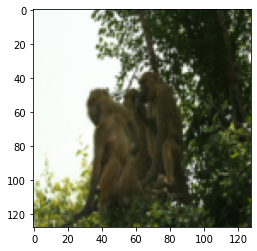

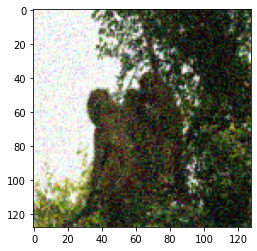

 35%|███▌      | 99/282 [00:12<00:11, 15.31it/s]

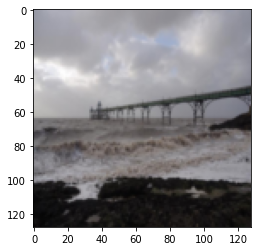

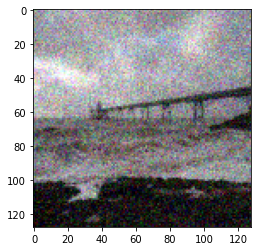

 71%|███████   | 199/282 [00:19<00:05, 14.87it/s]

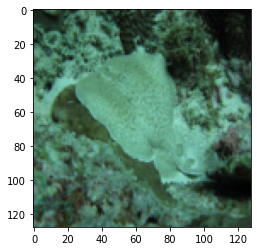

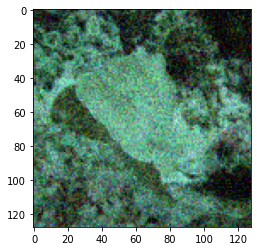

100%|██████████| 282/282 [00:25<00:00, 11.05it/s]


In [ ]:
import torch
import torch.utils.data  as data
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image

def image_show(img):
  if isinstance(img, torch.Tensor):
    img = transforms.ToPILImage()(img)
  plt.imshow(img)
  plt.show()

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = NoiseDataset(root_path, 128)
train_dataset.set_mode("training")

train_dataloader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

for i, data in enumerate(tqdm.tqdm(train_dataloader)):
  if use_cuda:
    img = data["img"].to('cuda')
    noise = data["noise"].to('cuda')
  
  model_input = img + noise
  noise_image = torch.clamp(model_input, 0, 1)


  if i % 100 == 0:
    image_show(img[0])
    image_show(noise_image[0])



# model

In [ ]:
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from torch.autograd import Variable
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
from torchsummary import summary

def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer

def conv_down(in_chn, out_chn, bias=False): #픽셀 절반으로 down
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=4, stride=2, padding=1, bias=bias)
    return layer

def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)

## Supervised Attention Module
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size=3, bias=True):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        x2 = torch.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.down_path_1 = nn.ModuleList()
        self.down_path_2 = nn.ModuleList()
        self.up_path_1 = nn.ModuleList()
        self.up_path_2 = nn.ModuleList()
        self.skip_conv_1 = nn.ModuleList()
        self.skip_conv_2 = nn.ModuleList()

        self.conv_01 = nn.Conv2d(3, 64, 3, 1, 1) # 픽셀 변화 없이 채널만 3 -> 64
        self.conv_02 = nn.Conv2d(3, 64, 3, 1, 1) # 픽셀 변화 없이 채널만 3 -> 64

        self.down_path_1.append(UNetDown(64, 64, True, 0.2))
        self.down_path_1.append(UNetDown(64, 128, True, 0.2))
        self.down_path_1.append(UNetDown(128, 256, True, 0.2))
        self.down_path_1.append(UNetDown(256, 512, True, 0.2))
        self.down_path_1.append(UNetDown(512, 1024, False, 0.2))

        self.up_path_1.append(UNetUp(1024, 512, 0.2))
        self.skip_conv_1.append(nn.Conv2d(512, 512, 3, 1, 1))

        self.up_path_1.append(UNetUp(512, 256, 0.2))
        self.skip_conv_1.append(nn.Conv2d(256, 256, 3, 1, 1))

        self.up_path_1.append(UNetUp(256, 128, 0.2))
        self.skip_conv_1.append(nn.Conv2d(128, 128, 3, 1, 1))

        self.up_path_1.append(UNetUp(128, 64, 0.2))
        self.skip_conv_1.append(nn.Conv2d(64, 64, 3, 1, 1))


        self.sam12 = SAM(64)
        self.cat12 = nn.Conv2d(128, 64, 1, 1, 0)

        self.down_path_2.append(UNetDown(64, 64, True, 0.2))
        self.down_path_2.append(UNetDown(64, 128, True, 0.2))
        self.down_path_2.append(UNetDown(128, 256, True, 0.2))
        self.down_path_2.append(UNetDown(256, 512, True, 0.2))
        self.down_path_2.append(UNetDown(512, 1024, False, 0.2))

        self.up_path_2.append(UNetUp(1024, 512, 0.2))
        self.skip_conv_2.append(nn.Conv2d(512, 512, 3, 1, 1))

        self.up_path_2.append(UNetUp(512, 256, 0.2))
        self.skip_conv_2.append(nn.Conv2d(256, 256, 3, 1, 1))

        self.up_path_2.append(UNetUp(256, 128, 0.2))
        self.skip_conv_2.append(nn.Conv2d(128, 128, 3, 1, 1))

        self.up_path_2.append(UNetUp(128, 64, 0.2))
        self.skip_conv_2.append(nn.Conv2d(64, 64, 3, 1, 1))

        self.last = conv3x3(64, 3, bias=True)

    def forward(self, x):
        image = x

        x1 = self.conv_01(image) #3c -> 64c
        encs = []
        for i, down in enumerate(self.down_path_1):
            if (i+1) < 5:
                x1, x1_up = down(x1)
                encs.append(x1_up)
            else:
                x1 = down(x1)

        for i, up in enumerate(self.up_path_1):
            x1 = up(x1, self.skip_conv_1[i](encs[-i-1]))


        sam_feature, out_1 = self.sam12(x1, image)

        x2 = self.conv_02(image)
        x2 = self.cat12(torch.cat([x2, sam_feature], dim=1))
        
        encs2 = []
        for i, down in enumerate(self.down_path_2):
            if (i+1) < 5:
                x2, x2_up = down(x2)
                encs2.append(x2_up)
            else:
                x2 = down(x2)

        for i, up in enumerate(self.up_path_1):
            x2 = up(x2, self.skip_conv_2[i](encs2[-i-1]))

        out_2 = self.last(x2)
        out_2 = out_2 + image
        return [out_1, out_2]




class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, downsample, relu_slope):
        super(UNetDown, self).__init__()
        self.downsample = downsample
        self.identity = nn.Conv2d(in_size, out_size, 1, 1, 0)

        self.conv_1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=True) #채널 변경, 픽셀변경 없음
        self.relu_1 = nn.LeakyReLU(relu_slope, inplace=False)# 리키렐루 경사각만 조정
        self.conv_2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, bias=True) #채널 픽셀 변경없이 conv 1층 추가
        self.relu_2 = nn.LeakyReLU(relu_slope, inplace=False)# 리키렐루 경사각만 조정

        if downsample:
            self.downsample = conv_down(out_size, out_size, bias=False) #크기 절반으로 down

    def forward(self, x):
        out = self.conv_1(x)

        out = self.relu_1(out)
        out = self.relu_2(self.conv_2(out))

        out += self.identity(x)

        if self.downsample:
            out_down = self.downsample(out)
            return out_down, out
        else:
            return out


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, relu_slope):
        super(UNetUp, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.conv_block = UNetDown(in_size, out_size, False, relu_slope)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], 1)
        out = self.conv_block(out)
        return out


class skip_blocks(nn.Module):

    def __init__(self, in_size, out_size):
        super(skip_blocks, self).__init__()
        self.blocks = nn.ModuleList()
        self.blocks.append(UNetDown(in_size, 128, False, 0.2))
        self.blocks.append(UNetDown(128, out_size, False, 0.2))
        self.shortcut = nn.Conv2d(in_size, out_size, kernel_size=1, bias=True)

    def forward(self, x):
        sc = self.shortcut(x)
        for m in self.blocks:
            x = m(x)
        return x + sc



In [ ]:
summary(Net().cuda(), (3, 128, 128)) #모델 요약

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2         [-1, 64, 128, 128]          36,928
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
         LeakyReLU-5         [-1, 64, 128, 128]               0
            Conv2d-6         [-1, 64, 128, 128]           4,160
            Conv2d-7           [-1, 64, 64, 64]          65,536
          UNetDown-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
        LeakyReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
        LeakyReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]           8,320
           Conv2d-14      

In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        # nn.init.uniform(m.weight.data, 1.0, 0.02)
        m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
        nn.init.constant(m.bias.data, 0.0)

In [ ]:
import math

model = Net().cuda() #모델 정의
# model.apply(weights_init_kaiming)

# model = torch.load("/content/model_epoch_35.pth")
# model = model['arch'].cuda()
# model.load_state_dict(model['state_dict'])  # state_dict를 불러 온 후, 모델에 저장


MSE = nn.MSELoss()
# MSE = PSNRLoss()
# fn_loss = CharbonnierLoss()

# model = torch.load("/content/model_epoch_5.pth")
# model = model['arch'].cuda()

# fn_loss = CharbonnierLoss()
# optimizer = optim.Adam(model.parameters(),lr=1e-4)

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-8)
# optimizer = optim.Adam(model.parameters(), lr=lr) # Adam Optimizer

In [ ]:
def remove_noise(model, image): # 노이즈 이미지 - model output 이미지 계산 함수
    out = torch.clamp(image - model(image), 0., 1.)
    # out = image - model(image)
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    plt.show()

def img_show(image): # 노이즈 이미지 - model output 이미지 계산 함수
    out = torch.clamp(image, 0., 1.)
    # out = image
    out = out.cpu().clone()
    out = out.squeeze(0)
    trans = transforms.ToPILImage()
    plt.imshow(trans(out))
    plt.show()

In [ ]:
from skimage.measure.simple_metrics import compare_psnr
def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i, :, :, :], Img[i, :, :, :], data_range=data_range)
    return (PSNR/Img.shape[0])

ts = transforms.ToPILImage() # tensor 배열을 이미지로 변환
def train(epoch): # epoch 만큼 학습 반복
    epoch_loss = 0
    for iteration, data in enumerate(train_dataloader, 1):


        model.train()
        model.zero_grad()
        optimizer.zero_grad()

        target = data["img"] #target = 원본 사진
        noise = data["noise"] #노이즈만 있는 사진
        model_input = target + noise


        noise = Variable(noise.cuda())
        target = Variable(target.cuda())
        model_input = Variable(model_input.cuda())

        output = model(model_input)
        
        psnr_train = batch_PSNR(output[1],target, 1.)
        psnr_train2 = batch_PSNR(output[0],target, 1.)
        # loss = np.sum([fn_loss(torch.clamp(output[j],0,1),target) for j in range(len(output))])
        loss = MSE(output[1], target) + MSE(output[0], target)
        epoch_loss += loss.item() 


        loss.backward()
        optimizer.step()


        if iteration % 100 == 0:

          # remove_noise(model,model_input[0].view([-1, 3, 128, 128]).cuda())
          # img_show(real_output[0].view([-1, 3, 128, 128]).cuda())
          # img_show(output[0][0].view([-1, 3, 128, 128]).cuda())
          # img_show(output[1][0].view([-1, 3, 128, 128]).cuda())
          # img_show(output[2][0].view([-1, 3, 128, 128]).cuda())
          img_show(output[0][0].view([-1, 3, 128, 128]).cuda())
          img_show(output[1][0].view([-1, 3, 128, 128]).cuda())
          img_show(target[0].view([-1, 3, 128, 128]).cuda())
          img_show(model_input[0].view([-1, 3, 128, 128]).cuda())

          # img_show(output[0].view([-1, 3, 128, 128]).cuda())

        print("Epoch[{}]({}/{}): Loss: {:.4f} : psnr {},psnr {}".format(epoch, iteration, len(train_dataloader), loss.item(), psnr_train,psnr_train2))

    print("Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(train_dataloader)))

In [ ]:
def save_checkpoint(state): #epoch 마다 모델 저장
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

Epoch[9](269/282): Loss: 0.0019 : psnr 30.687384996876172,psnr 30.51285549080239
Epoch[9](270/282): Loss: 0.0022 : psnr 29.893623894404186,psnr 29.744393836156373
Epoch[9](271/282): Loss: 0.0017 : psnr 31.163363355432992,psnr 30.963361102903036
Epoch[9](272/282): Loss: 0.0020 : psnr 30.626054524291046,psnr 30.423579430066404
Epoch[9](273/282): Loss: 0.0023 : psnr 29.78422867975377,psnr 29.617577833498544
Epoch[9](274/282): Loss: 0.0021 : psnr 30.148594424830915,psnr 29.96488928143531
Epoch[9](275/282): Loss: 0.0019 : psnr 30.601777602901894,psnr 30.425899490263564
Epoch[9](276/282): Loss: 0.0018 : psnr 31.02920411875018,psnr 30.826672319184077
Epoch[9](277/282): Loss: 0.0019 : psnr 30.399151678978747,psnr 30.20807331979268
Epoch[9](278/282): Loss: 0.0017 : psnr 31.079812878273994,psnr 30.86409710061237
Epoch[9](279/282): Loss: 0.0018 : psnr 30.87769548591786,psnr 30.672677954938177
Epoch[9](280/282): Loss: 0.0018 : psnr 30.74110707629087,psnr 30.544983480777645
Epoch[9](281/282): Loss:

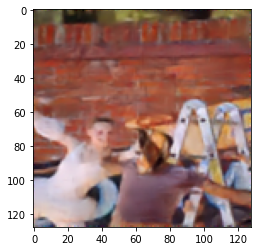

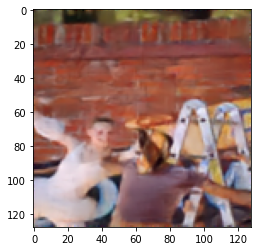

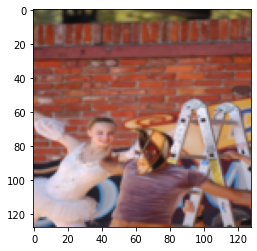

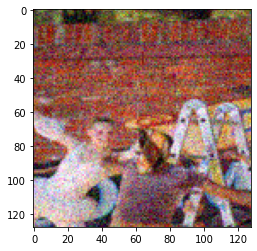

Epoch[10](100/282): Loss: 0.0019 : psnr 30.837845576819866,psnr 30.64604078015447
Epoch[10](101/282): Loss: 0.0015 : psnr 31.527149052001924,psnr 31.295946674621522
Epoch[10](102/282): Loss: 0.0022 : psnr 30.072753661934197,psnr 29.901571616847622
Epoch[10](103/282): Loss: 0.0018 : psnr 30.813978031555695,psnr 30.57503102248244
Epoch[10](104/282): Loss: 0.0019 : psnr 30.381654192859422,psnr 30.20798928053048
Epoch[10](105/282): Loss: 0.0018 : psnr 30.81971198706416,psnr 30.621582644515822
Epoch[10](106/282): Loss: 0.0019 : psnr 30.745109497362776,psnr 30.537171231386903
Epoch[10](107/282): Loss: 0.0018 : psnr 30.931770863940148,psnr 30.744051973116555
Epoch[10](108/282): Loss: 0.0018 : psnr 30.865288129780087,psnr 30.646292976889438
Epoch[10](109/282): Loss: 0.0018 : psnr 30.69536460306007,psnr 30.530557043468914
Epoch[10](110/282): Loss: 0.0022 : psnr 29.86696768896054,psnr 29.712385880472116
Epoch[10](111/282): Loss: 0.0024 : psnr 29.54091936984276,psnr 29.392402940093216
Epoch[10](1

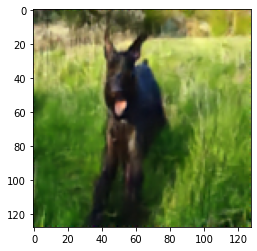

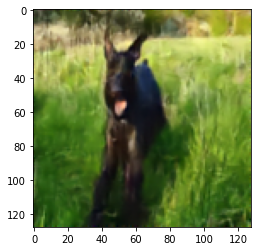

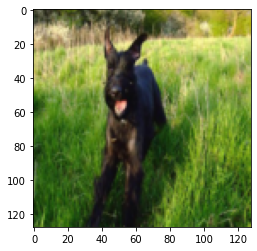

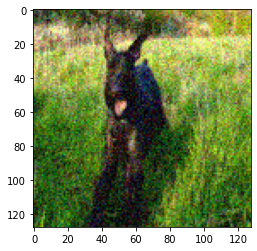

Epoch[10](200/282): Loss: 0.0017 : psnr 31.53699320906922,psnr 31.32222212479568
Epoch[10](201/282): Loss: 0.0023 : psnr 29.650436319529376,psnr 29.525823399858904
Epoch[10](202/282): Loss: 0.0020 : psnr 30.483058890078727,psnr 30.289644408882932
Epoch[10](203/282): Loss: 0.0027 : psnr 29.200428055633367,psnr 29.048275702667738
Epoch[10](204/282): Loss: 0.0024 : psnr 29.548217891586724,psnr 29.39436485580346
Epoch[10](205/282): Loss: 0.0020 : psnr 30.568049048357068,psnr 30.419834998272147
Epoch[10](206/282): Loss: 0.0019 : psnr 30.739339781570926,psnr 30.530470553374915
Epoch[10](207/282): Loss: 0.0021 : psnr 30.21205519480282,psnr 29.99850080594841
Epoch[10](208/282): Loss: 0.0020 : psnr 30.560128460232292,psnr 30.375339768194056
Epoch[10](209/282): Loss: 0.0021 : psnr 30.20324797043049,psnr 30.008850718098245
Epoch[10](210/282): Loss: 0.0021 : psnr 30.393688399616615,psnr 30.150298161264182
Epoch[10](211/282): Loss: 0.0018 : psnr 30.715867290525225,psnr 30.528518988447857
Epoch[10](

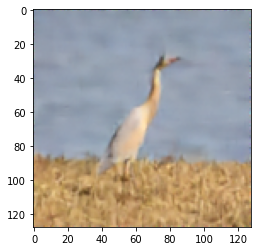

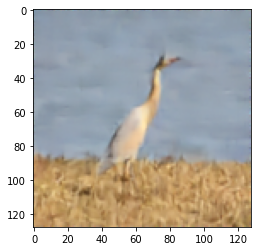

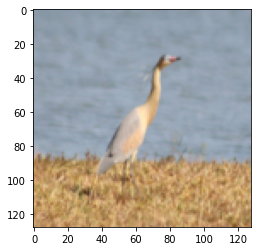

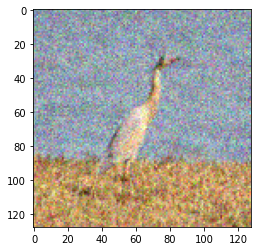

Epoch[11](100/282): Loss: 0.0021 : psnr 30.14361889738196,psnr 29.9465675117118
Epoch[11](101/282): Loss: 0.0021 : psnr 30.10884989383565,psnr 29.91731474103643
Epoch[11](102/282): Loss: 0.0018 : psnr 30.71924596756446,psnr 30.50662388540729
Epoch[11](103/282): Loss: 0.0018 : psnr 30.750758869120812,psnr 30.51834906120757
Epoch[11](104/282): Loss: 0.0018 : psnr 30.860372642911894,psnr 30.675530566551778
Epoch[11](105/282): Loss: 0.0017 : psnr 30.93423989896454,psnr 30.67687806135617
Epoch[11](106/282): Loss: 0.0017 : psnr 31.171273521677794,psnr 30.940185041239634
Epoch[11](107/282): Loss: 0.0019 : psnr 30.670043277103115,psnr 30.475431035693127
Epoch[11](108/282): Loss: 0.0017 : psnr 31.312139609551043,psnr 31.03759060819867
Epoch[11](109/282): Loss: 0.0017 : psnr 31.0623750123398,psnr 30.863300858742342
Epoch[11](110/282): Loss: 0.0019 : psnr 30.736217776599382,psnr 30.536710084081243
Epoch[11](111/282): Loss: 0.0022 : psnr 30.197861499313333,psnr 30.020554852630468
Epoch[11](112/282

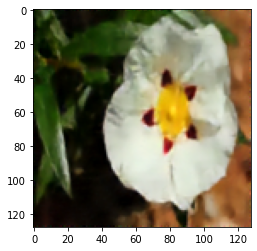

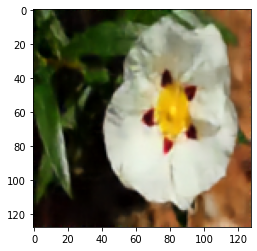

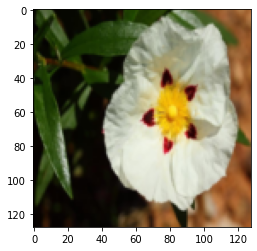

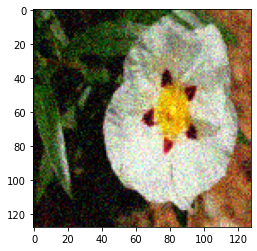

Epoch[11](200/282): Loss: 0.0017 : psnr 31.041952117248925,psnr 30.8234956523043
Epoch[11](201/282): Loss: 0.0016 : psnr 31.38789397795347,psnr 31.16758836210894
Epoch[11](202/282): Loss: 0.0016 : psnr 31.259723897382717,psnr 31.08428372013621
Epoch[11](203/282): Loss: 0.0019 : psnr 30.655190848859274,psnr 30.46921994911219
Epoch[11](204/282): Loss: 0.0019 : psnr 30.716252256926087,psnr 30.521770694673133
Epoch[11](205/282): Loss: 0.0020 : psnr 30.273525525746933,psnr 30.108750608649647
Epoch[11](206/282): Loss: 0.0018 : psnr 30.97592677940844,psnr 30.76366470331723
Epoch[11](207/282): Loss: 0.0023 : psnr 29.725200625645623,psnr 29.55613736754068
Epoch[11](208/282): Loss: 0.0015 : psnr 31.515738017215185,psnr 31.27265929291961
Epoch[11](209/282): Loss: 0.0015 : psnr 32.16129168917883,psnr 31.84658529596707
Epoch[11](210/282): Loss: 0.0017 : psnr 31.179184877098876,psnr 30.97641062066886
Epoch[11](211/282): Loss: 0.0017 : psnr 30.943840126489913,psnr 30.750975571328546
Epoch[11](212/282

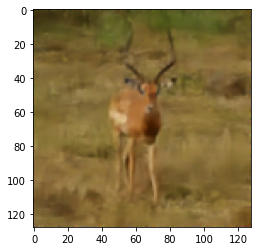

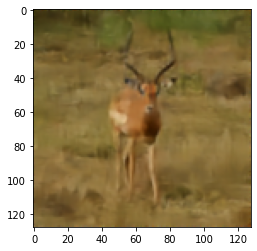

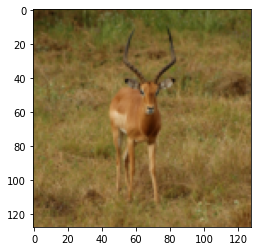

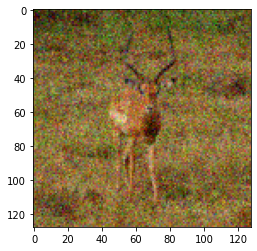

Epoch[12](100/282): Loss: 0.0019 : psnr 30.58787315019778,psnr 30.413370956058458
Epoch[12](101/282): Loss: 0.0020 : psnr 30.313406773601766,psnr 30.139479606585894
Epoch[12](102/282): Loss: 0.0017 : psnr 31.48963010978906,psnr 31.25650072164299
Epoch[12](103/282): Loss: 0.0020 : psnr 30.471189276391506,psnr 30.264859851797535
Epoch[12](104/282): Loss: 0.0018 : psnr 30.61509120616652,psnr 30.44346436569789
Epoch[12](105/282): Loss: 0.0021 : psnr 30.135626005279608,psnr 29.985198029283207
Epoch[12](106/282): Loss: 0.0018 : psnr 30.616255674469528,psnr 30.43895425660263
Epoch[12](107/282): Loss: 0.0019 : psnr 30.592631028961264,psnr 30.41031832764105
Epoch[12](108/282): Loss: 0.0018 : psnr 30.956263808651535,psnr 30.749197028540365
Epoch[12](109/282): Loss: 0.0018 : psnr 30.788357428408823,psnr 30.5952549110448
Epoch[12](110/282): Loss: 0.0015 : psnr 31.580594397544875,psnr 31.352314420955267
Epoch[12](111/282): Loss: 0.0018 : psnr 30.856451839673287,psnr 30.653356097178108
Epoch[12](112

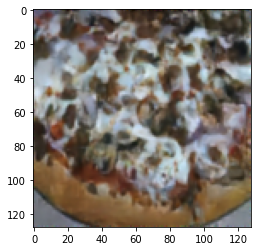

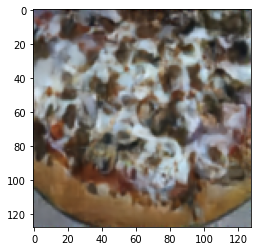

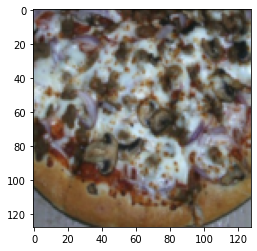

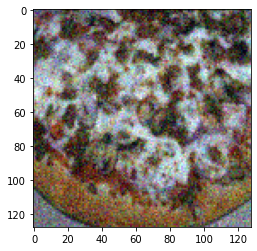

Epoch[12](200/282): Loss: 0.0019 : psnr 30.791855457872597,psnr 30.584759637512253
Epoch[12](201/282): Loss: 0.0024 : psnr 29.58756438823954,psnr 29.436502013029394
Epoch[12](202/282): Loss: 0.0017 : psnr 31.005008903106955,psnr 30.834748976956337
Epoch[12](203/282): Loss: 0.0020 : psnr 30.536440451278864,psnr 30.34165204503458
Epoch[12](204/282): Loss: 0.0017 : psnr 30.987999064854616,psnr 30.7775108249034
Epoch[12](205/282): Loss: 0.0022 : psnr 30.050261405667783,psnr 29.878516831532334
Epoch[12](206/282): Loss: 0.0019 : psnr 30.835156334278448,psnr 30.644477667988024
Epoch[12](207/282): Loss: 0.0019 : psnr 30.49196367279098,psnr 30.325899537361447
Epoch[12](208/282): Loss: 0.0017 : psnr 31.084006480509817,psnr 30.85010642069624
Epoch[12](209/282): Loss: 0.0019 : psnr 30.92060074553727,psnr 30.69410581242494
Epoch[12](210/282): Loss: 0.0016 : psnr 31.548954144748514,psnr 31.293711753263167
Epoch[12](211/282): Loss: 0.0018 : psnr 30.898162750060564,psnr 30.667756969174043
Epoch[12](21

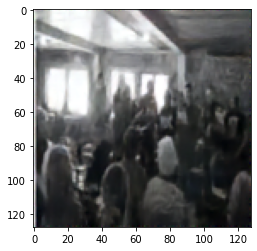

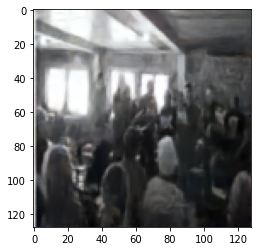

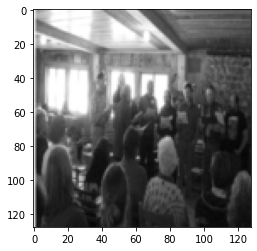

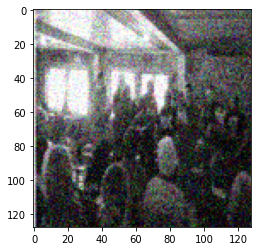

Epoch[13](100/282): Loss: 0.0016 : psnr 31.48053162608256,psnr 31.2685740242831
Epoch[13](101/282): Loss: 0.0017 : psnr 31.045170849492298,psnr 30.850497460809944
Epoch[13](102/282): Loss: 0.0017 : psnr 31.100992771553152,psnr 30.930550343006058
Epoch[13](103/282): Loss: 0.0018 : psnr 30.920632674749882,psnr 30.756912703004204
Epoch[13](104/282): Loss: 0.0018 : psnr 30.6939738461925,psnr 30.546005818735175
Epoch[13](105/282): Loss: 0.0017 : psnr 31.012128443249598,psnr 30.8199852280653
Epoch[13](106/282): Loss: 0.0019 : psnr 30.664411916803274,psnr 30.48750904064171
Epoch[13](107/282): Loss: 0.0019 : psnr 30.61961579558922,psnr 30.42686374497992
Epoch[13](108/282): Loss: 0.0015 : psnr 31.564202218635394,psnr 31.385852019257715
Epoch[13](109/282): Loss: 0.0019 : psnr 30.695771273666846,psnr 30.53309043730523
Epoch[13](110/282): Loss: 0.0020 : psnr 30.341540905778512,psnr 30.15671103317876
Epoch[13](111/282): Loss: 0.0018 : psnr 30.813349964784123,psnr 30.635781737541457
Epoch[13](112/28

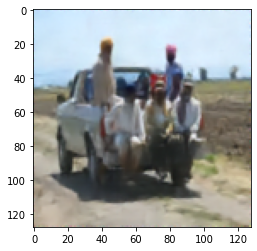

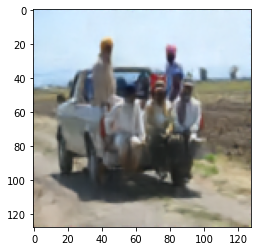

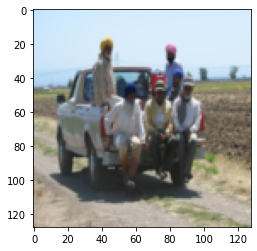

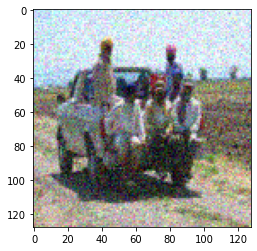

Epoch[13](200/282): Loss: 0.0021 : psnr 30.261933989543422,psnr 30.07276731050031
Epoch[13](201/282): Loss: 0.0021 : psnr 30.35586103242773,psnr 30.21533330436394
Epoch[13](202/282): Loss: 0.0018 : psnr 30.950439182020325,psnr 30.751910075842417
Epoch[13](203/282): Loss: 0.0020 : psnr 30.4554027030646,psnr 30.299693390057865
Epoch[13](204/282): Loss: 0.0019 : psnr 30.648390180355687,psnr 30.474661581768817
Epoch[13](205/282): Loss: 0.0021 : psnr 29.941762310646034,psnr 29.807175976293095
Epoch[13](206/282): Loss: 0.0015 : psnr 31.896395930054965,psnr 31.650444731457288
Epoch[13](207/282): Loss: 0.0016 : psnr 31.192667598905594,psnr 31.007533474062313
Epoch[13](208/282): Loss: 0.0018 : psnr 31.079414128618353,psnr 30.871681083230058
Epoch[13](209/282): Loss: 0.0017 : psnr 31.160412672100342,psnr 30.976413962158453
Epoch[13](210/282): Loss: 0.0018 : psnr 30.77004928320681,psnr 30.60352617047735
Epoch[13](211/282): Loss: 0.0018 : psnr 30.969046727711245,psnr 30.787458906084574
Epoch[13](2

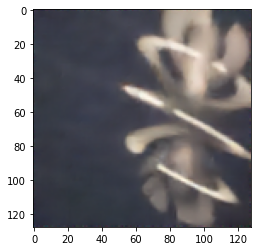

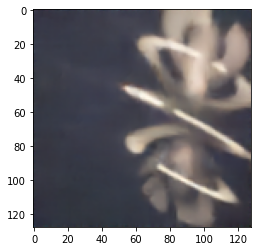

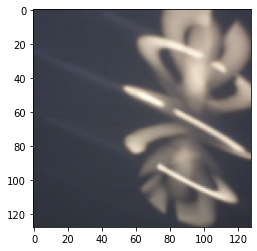

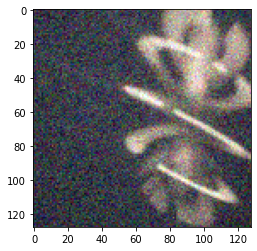

Epoch[14](100/282): Loss: 0.0015 : psnr 31.800734284158533,psnr 31.59623939628957
Epoch[14](101/282): Loss: 0.0020 : psnr 30.5879200927728,psnr 30.425262025000293
Epoch[14](102/282): Loss: 0.0021 : psnr 30.300995945747463,psnr 30.157454094595323
Epoch[14](103/282): Loss: 0.0022 : psnr 30.15331560026293,psnr 30.022746478148097
Epoch[14](104/282): Loss: 0.0020 : psnr 30.24039792703832,psnr 30.082977051437815
Epoch[14](105/282): Loss: 0.0017 : psnr 31.13127950418254,psnr 30.9806656778627
Epoch[14](106/282): Loss: 0.0016 : psnr 31.357305602396032,psnr 31.133395332005023
Epoch[14](107/282): Loss: 0.0018 : psnr 30.68279784509752,psnr 30.521311757355882
Epoch[14](108/282): Loss: 0.0018 : psnr 31.161828204207453,psnr 30.988585496475537
Epoch[14](109/282): Loss: 0.0017 : psnr 31.150993876452528,psnr 30.988776753373237
Epoch[14](110/282): Loss: 0.0019 : psnr 30.51444399368611,psnr 30.382880138474842
Epoch[14](111/282): Loss: 0.0022 : psnr 30.087516559869325,psnr 29.949787028806355
Epoch[14](112/

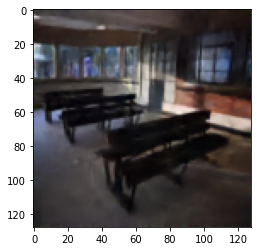

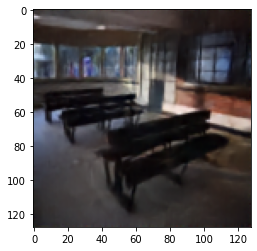

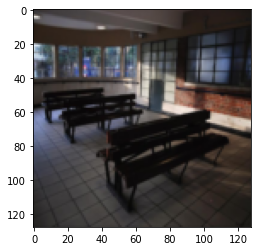

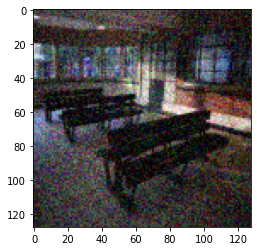

Epoch[14](200/282): Loss: 0.0018 : psnr 30.870417888607882,psnr 30.70139200577787
Epoch[14](201/282): Loss: 0.0016 : psnr 31.26709231447469,psnr 31.087004986571053
Epoch[14](202/282): Loss: 0.0019 : psnr 30.622911007594993,psnr 30.449346592839348
Epoch[14](203/282): Loss: 0.0020 : psnr 30.38102661448972,psnr 30.22806699250328
Epoch[14](204/282): Loss: 0.0014 : psnr 32.24857334794929,psnr 32.030699469134426
Epoch[14](205/282): Loss: 0.0017 : psnr 31.05009151605754,psnr 30.905453076302074
Epoch[14](206/282): Loss: 0.0020 : psnr 30.48741849585106,psnr 30.34828056281168
Epoch[14](207/282): Loss: 0.0018 : psnr 30.866034856913046,psnr 30.70104450810691
Epoch[14](208/282): Loss: 0.0021 : psnr 30.40138636746631,psnr 30.251049113873755
Epoch[14](209/282): Loss: 0.0017 : psnr 30.861533182946918,psnr 30.688651279926656
Epoch[14](210/282): Loss: 0.0020 : psnr 30.419693800825122,psnr 30.279541578431363
Epoch[14](211/282): Loss: 0.0018 : psnr 30.985583869236848,psnr 30.82193875104968
Epoch[14](212/2

In [ ]:
num_epochs = 1000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 1 == 0:
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

In [ ]:
model = torch.load('/content/model_epoch_35.pth') # 모델 경로 불러오기
model = model['arch'] # 모델 구조 추출

def image_loader(image_name): # 이미지 로더
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 

    return image.cuda()

val_dataset = NoiseDataset(root_path, 128)
val_dataset.set_mode("validation")

print(len(val_dataset))
loss = 0
for img in val_dataset:
  model_input = img["img"] + img["noise"]
  output = model(model_input.view([-1, 3, 128, 128]).cuda())
  psnr_train = batch_PSNR(output[1],img["img"].view([-1, 3, 128, 128]), 1.)
  loss += psnr_train
  print(psnr_train)

print(loss / 500)